In [1]:
# General libraries
import os 
import math
import glob
import numpy as np
from matplotlib import pyplot as plt
import cv2

# PyTorch related libraries
import torch  
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
import Auto_encoder, Config, Dataset 

# Specify GPUs to use
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  

In [2]:
# Calculating SSIM loss function
def ssim_loss(y_true, y_pred):
    """Calculate SSIM loss for each image in the batch"""
    mu_x = torch.mean(y_pred, dim=(2, 3), keepdim=True)
    mu_y = torch.mean(y_true, dim=(2, 3), keepdim=True)
    sigma_x = torch.var(y_pred, dim=(2, 3), keepdim=True)
    sigma_y = torch.var(y_true, dim=(2, 3), keepdim=True)
    covariance = ((y_pred - mu_x) * (y_true - mu_y)).mean(dim=(2, 3), keepdim=True)
    c1, c2 = 0.01**2, 0.03**2
    ssim = ((2 * mu_x * mu_y + c1) * (2 * covariance + c2)) / (
        (mu_x**2 + mu_y**2 + c1) * (sigma_x + sigma_y + c2)
    )
    # Return per-image SSIM loss (1 - SSIM) with shape [batch_size]
    return (1 - ssim).squeeze()

In [3]:
# Reconstruing input images
def visualize_reconstruction(model, data_loader, num_images=6): 
    model.eval()
    
    # Get a batch of images from the data loader
    batch = next(iter(data_loader))
    
    # If batch is a tuple/list (e.g., if it contains labels), take just the images
    if isinstance(batch, (tuple, list)):
        input_images = batch[0]
    else:
        input_images = batch
        
    # Move input images to the same device as the model
    device = next(model.parameters()).device
    input_images = input_images.to(device)
    
    # Select only the number of images we want to display
    input_images = input_images[:num_images]

    # Calculate reconstructions and losses
    with torch.no_grad():
        reconstructions = model(input_images)
        
        # Calculate per-image MSE loss
        mse_loss = torch.nn.MSELoss(reduction='none')(input_images, reconstructions)
        mse_loss = mse_loss.mean(dim=[1, 2, 3])  # Average over C,H,W dimensions
        ssim = ssim_loss(reconstructions, input_images)
        # Calculate PSNR while still in tensor form
        psnr = -10 * torch.log10(mse_loss)
        
        # Convert to numpy after all tensor operations are done
        mse_loss = mse_loss.cpu().numpy()
        psnr = psnr.cpu().numpy()

    # Convert tensors to numpy arrays for visualization
    input_images = input_images.cpu().numpy()
    reconstructions = reconstructions.cpu().numpy()

    # Create figure with more height to accommodate metrics
    fig = plt.figure(figsize=(2*num_images, 6))
    gs = plt.GridSpec(3, num_images, height_ratios=[4, 4, 1])
    
    for i in range(num_images):
        # Original images
        ax1 = fig.add_subplot(gs[0, i])
        orig_img = input_images[i].transpose(1, 2, 0)  # CHW to HWC
        orig_img = np.clip(orig_img, 0, 1)  # Ensure values are in [0, 1]
        ax1.imshow(orig_img)
        ax1.axis('off')
        if i == 0:
            ax1.set_title('Original')
            
        # Reconstructed images
        ax2 = fig.add_subplot(gs[1, i])
        recon_img = reconstructions[i].transpose(1, 2, 0)  # CHW to HWC
        recon_img = np.clip(recon_img, 0, 1)  # Ensure values are in [0, 1]
        ax2.imshow(recon_img)
        ax2.axis('off')
        if i == 0:
            ax2.set_title('Reconstructed')
            
        # Add metrics text
        ax3 = fig.add_subplot(gs[2, i])
        ax3.text(0.5, 0.5, f'MSE: {mse_loss[i]:.4f}\nPSNR: {psnr[i]:.2f}dB',
                 horizontalalignment='center',
                 verticalalignment='center')
        ax3.axis('off')
    
    # Add overall metrics
    avg_mse = mse_loss.mean()
    avg_psnr = psnr.mean()
    plt.figtext(0.02, 0.02, f'Average MSE: {avg_mse:.4f}\nAverage PSNR: {avg_psnr:.2f}dB',
                bbox=dict(facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

In [4]:
# Obtaining GPU handle
def get_device():
    # Get the available device for computation (CPU or GPU). 
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    #print(device)
    if torch.cuda.is_available():
        print(f"\nAvailable GPUs: {[torch.cuda.get_device_name(i) for i in range(torch.cuda.device_count())]}")    
    else:
        print("\nUsing CPU.")
    #os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"  # Specify GPUs to use
    return device

In [5]:
# Display available GPUs
def prepare_test_data(path):
    # Prepare the test dataset and DataLoader. 
    print("\nTesting data loading phase....")
    test_transforms = transforms.Compose([
        transforms.Resize((Config.tile_size, Config.tile_size)),
        transforms.ToTensor(),
        #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224,0.225]),
    ])
    tile_dataset_test = Dataset.TileDatasetTest(path, transform=test_transforms)
    data_loader_test = DataLoader(tile_dataset_test, batch_size=8, num_workers=Config.num_workers, shuffle=True)
    print("\nNumber of samples in the test set is :",len(tile_dataset_test))
    return data_loader_test

In [6]:
def load_model(device, checkpoint_path):
    """Load model from checkpoint or regular model file"""
    print("\nInitializing the model...")
    loaded_model = Auto_encoder.AutoEncoder()
    
    # Load the checkpoint/model file
    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    # Check if this is a checkpoint file (with metadata) or regular model file
    if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
        # This is a checkpoint file with metadata
        print(f"Loading checkpoint from epoch {checkpoint.get('epoch', 'Unknown')} with training loss {checkpoint.get('loss', 'Unknown'):.4f}")
        state_dict = checkpoint['model_state_dict']
    else:
        # This is a regular model file (state_dict only)
        print("Loading regular model file")
        state_dict = checkpoint
    
    # Load the state dict into the model
    loaded_model.load_state_dict(state_dict)
    loaded_model.to(device)
    
    # Use DataParallel if multiple GPUs available
    if torch.cuda.device_count() > 1:
        loaded_model = nn.DataParallel(loaded_model)
        print(f"Using {torch.cuda.device_count()} GPUs")
    
    loaded_model.eval()  # Set to evaluation mode
    print("Model loaded successfully!")
    return loaded_model


Available GPUs: ['NVIDIA L40S']

Testing data loading phase....

Number of samples in the test set is : 70000

Initializing the model...
Loading checkpoint from epoch 20 with training loss 0.0002
Model loaded successfully!


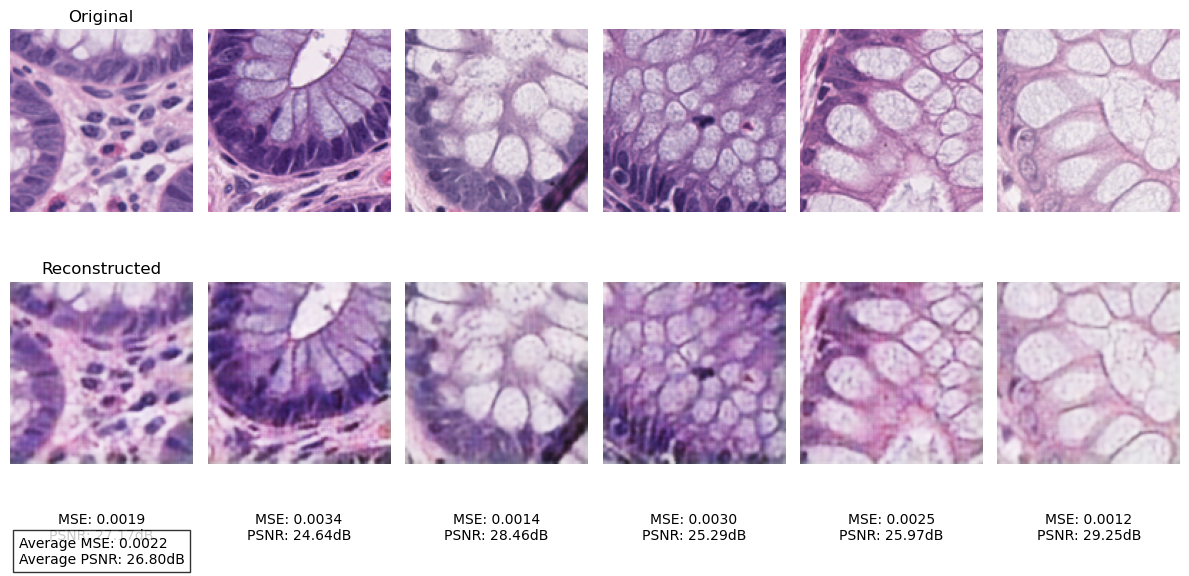

In [261]:
# Get device CPU or GPU to train the model
device = get_device()
# Adipose, Lymphocyte, Loose_connective_tissue, Mucin, Necrotic_debris, Normal, Red_blood_cells, Muscle
# Load the testing data
#sample_images = prepare_test_data('/data_64T_1/Raja/AutoEncoder/Filtered_Output/high_reconstruction_loss') 
sample_images = prepare_test_data('/data_64T_1/Barathi/Projects/Classification/NIPS_Training_dataset/4.Tiles_sampled/Normal') 
checkpoint_path = "checkpoints/Model_AE_epoch_020.pth"
# Load the trained model
model = load_model(device, checkpoint_path)

# if isinstance(sample_images, (list, tuple)):
#     sample_images = torch.stack(sample_images)
# # sample_images = sample_images.to(device)
visualize_reconstruction(model, sample_images)